In [39]:
import numpy as np
import pandas as pd
from DANNModel import Model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
from sklearn.metrics import accuracy_score
import cv2
from DANNtrain import train
from DisplayLogs import display_logs
import random
random.seed(222)


In [40]:

#define a function to standardize the image and resize it
def ppandresize(X, n_h, n_w):
    """
    :param X: image array of size nxhxwxc
    :param n_h: the required new height
    :param n_w: the required new width
    :return: image array of size nxn_h,n_wxc
    """
    new_size=(n_h,n_w)
    if X.dtype is np.uint8:
        X=X/255
    if X.dtype is np.float64:
        print('it is float 64')
        X=(X + 1) / 2.0  # Convert to the range [0, 1]
        # Optionally, ensure the values are clipped to [0, 1]
        X = np.clip(X, 0, 1)
    
    X_resized=np.zeros((X.shape[0], *new_size))
    for i in range(X.shape[0]):
        X_resized[i]=cv2.resize(X[i], new_size)
    return X_resized

#define a function to convert grayscale image to image with 3 channels
def graytoRGB(X):
    """
    :param X: grayscale image of size nxhxwx1
    :return: grayscale image of size nxhxwx3
    """
    X=np.stack((X,)*3, axis=-1)
    return X

In [41]:
# import mnist dataset and preprocess it as source data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train, y_train= X_train[0:60000], y_train[0:60000]
X_test, y_test= X_test[0:500], y_test[0:500]
X_train, X_test= X_train/255, X_test/255
X_train=ppandresize(X_train,32,32) 
X_train=graytoRGB(X_train) 

X_test=ppandresize(X_test,32,32)
X_test=graytoRGB(X_test)

In [42]:
#import usps data as target data
from extra_keras_datasets import usps
(X_t, y_t), (_, _)=usps.load_data()
X_t=ppandresize(X_t,32,32)
X_t=graytoRGB(X_t)
X_t=(X_t+1)/2
for i in range(4):
    X_t=np.concatenate([X_t, X_t], axis=0)
    y_t=np.concatenate([y_t, y_t], axis=0)
X_t, y_t= X_t[0:60000], y_t[0:60000]


INFO:root:Loading dataset = usps


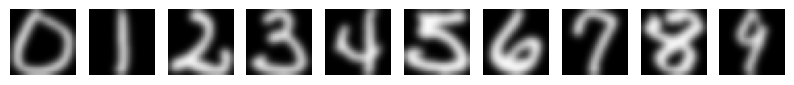

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
for digit in range(10):
    # Find the index of the first occurrence of the current digit
    index = next(i for i, label in enumerate(y_t) if label == digit)
    
    # Plot the image
    plt.subplot(1, 10, digit + 1)
    plt.imshow(X_t[index], cmap='gray')
    #plt.title(f'Digit {digit}')
    plt.axis('off')

plt.show()

In [44]:
X_t.shape

(60000, 32, 32, 3)

In [45]:
modelDA=Model()


In [46]:
trainer_DA=train(X_source=X_train, y_source= y_train, model=modelDA, batch_size=64, X_target=X_t, y_target= y_t, epochs=10, source_only=False)

Epoch 1 Loss: 1.2495745420455933
For epoch 1: {'accuracy_score_source': 0.988, 'accuracy_score_target': 0.6883}
Epoch 2 Loss: 1.210204005241394
For epoch 2: {'accuracy_score_source': 0.9924, 'accuracy_score_target': 0.679}
Epoch 3 Loss: 1.2027268409729004
For epoch 3: {'accuracy_score_source': 0.9954, 'accuracy_score_target': 0.6902}
Epoch 4 Loss: 1.1991243362426758
For epoch 4: {'accuracy_score_source': 0.996, 'accuracy_score_target': 0.7049}
Epoch 5 Loss: 1.1971125602722168
For epoch 5: {'accuracy_score_source': 0.9978, 'accuracy_score_target': 0.6977}
Epoch 6 Loss: 1.195969581604004
For epoch 6: {'accuracy_score_source': 0.9975, 'accuracy_score_target': 0.7063}
Epoch 7 Loss: 1.1952897310256958
For epoch 7: {'accuracy_score_source': 0.9977, 'accuracy_score_target': 0.701}
Epoch 8 Loss: 1.1948405504226685
For epoch 8: {'accuracy_score_source': 0.9981, 'accuracy_score_target': 0.704}
Epoch 9 Loss: 1.1945298910140991
For epoch 9: {'accuracy_score_source': 0.9978, 'accuracy_score_target'

In [47]:
y_pred_test=modelDA.predict_label(X_test)

In [48]:
accuracy_source=accuracy_score(np.argmax(y_pred_test, axis=1), y_test)
print(accuracy_source)

0.994


In [49]:
y_pred_test_target=modelDA.predict_label(X_t[0:1000])

In [50]:
y_pred_correct= y_pred_test_target[np.argmax(y_pred_test_target, axis=1)==y_t[0:1000]]

In [51]:
y_pred_confident= y_pred_correct[np.max(y_pred_correct, axis=1)>0.9]

In [52]:
determinacy= len(y_pred_confident)/len(y_pred_correct)
print(determinacy)

0.8744769874476988


In [53]:
accuracy_target=accuracy_score(np.argmax(y_pred_test_target, axis=1), y_t[0:1000])
print(accuracy_target)

0.717


In [54]:
y_target_sample=y_t[0:1000]

In [55]:
indices=[]
total_samples=[]
accurate_samples=[]
for i in range(10):
    indices.append(i)
    total_samples.append(len(y_target_sample[y_target_sample==i])/10)
    accurate_samples.append(accuracy_score(np.argmax(y_pred_test_target[y_target_sample==i], axis=1), y_target_sample[y_target_sample==i])*total_samples[-1])
    
    

In [56]:
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [57]:
print(total_samples)

[21.3, 12.0, 13.9, 7.0, 6.6, 4.7, 10.4, 7.5, 9.8, 6.8]


In [58]:
print(accurate_samples)

[20.8, 12.0, 8.9, 5.4, 5.1, 4.3, 7.4, 0.6, 7.200000000000001, 0.0]


In [59]:
y_9= y_pred_test_target[y_target_sample==9]

In [60]:
np.argmax(y_9,axis=1)

array([4, 1, 6, 4, 7, 7, 7, 1, 4, 7, 7, 4, 7, 7, 6, 4, 7, 1, 7, 1, 4, 4,
       4, 7, 1, 4, 4, 1, 4, 7, 4, 4, 1, 4, 4, 4, 7, 7, 1, 7, 7, 7, 7, 4,
       4, 4, 1, 4, 4, 7, 7, 7, 7, 7, 4, 7, 4, 1, 4, 1, 4, 7, 4, 7, 7, 4,
       4, 7], dtype=int64)

In [61]:
diversity = {'Numbers': indices, 'Total Samples': total_samples, 'Accurate Samples': accurate_samples}
diversity_df = pd.DataFrame(diversity)
diversity_df.set_index('Numbers')

,Total Samples,Accurate Samples
Numbers,,
0,21.3,20.8
1,12.0,12.0
2,13.9,8.9
3,7.0,5.4
4,6.6,5.1
5,4.7,4.3
6,10.4,7.4
7,7.5,0.6
8,9.8,7.2


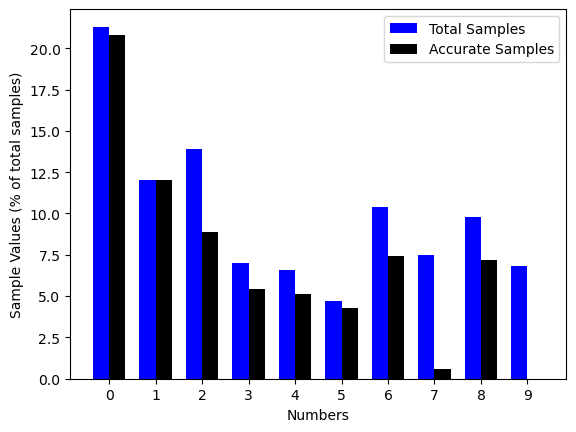

In [62]:


# Assuming you have the DataFrame diversity_df

# Create a figure and axis
fig, ax = plt.subplots()

# Define bar width and the number of indices
bar_width = 0.35
indices = diversity_df['Numbers']
x = range(len(indices))

# Plot Total Samples
total_samples = diversity_df['Total Samples']
rect1 = ax.bar(x, total_samples, width=bar_width, label='Total Samples', color='b')

# Plot Accurate Samples
accurate_samples = diversity_df['Accurate Samples']
rect2 = ax.bar([i + bar_width for i in x], accurate_samples, width=bar_width, label='Accurate Samples', color='black')

# Set x-axis labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(indices)

# Set axis labels and title
plt.xlabel('Numbers')
plt.ylabel('Sample Values (% of total samples)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


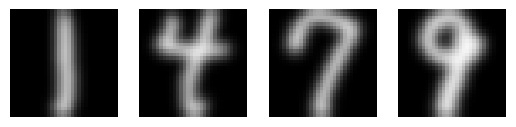

In [63]:
fig, ax= plt.subplots(1,4)
ax[0].set_axis_off()
ax[0].imshow(X_t[y_t==1][0])
ax[1].set_axis_off()
ax[1].imshow(X_t[y_t==4][1])
ax[2].set_axis_off()
ax[2].imshow(X_t[y_t==7][0])
ax[3].set_axis_off()
ax[3].imshow(X_t[y_t==9][1])


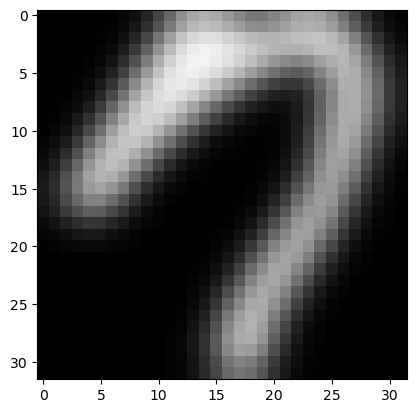

In [64]:
plt.imshow(X_t[y_t==7][1])


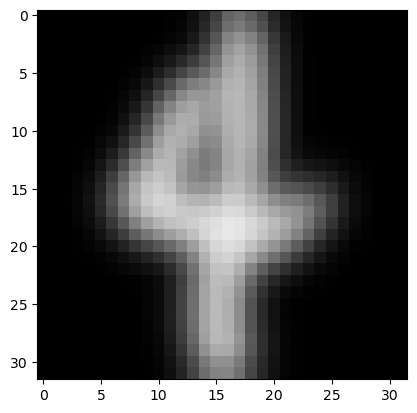

In [65]:
plt.imshow(X_t[y_t==4][2])

In [66]:
modelnotDA=Model()

In [67]:
trainernotDA= train(X_source=X_train, y_source= y_train, model=modelnotDA, X_target= X_t, y_target= y_t, batch_size=32, epochs=10, source_only=True)

Epoch 1 Loss: 0.12337394803762436
For epoch 1: {'accuracy_score_source': 0.9917, 'accuracy_score_target': 0.2965}
Epoch 2 Loss: 0.03562546521425247
For epoch 2: {'accuracy_score_source': 0.9949, 'accuracy_score_target': 0.2982}
Epoch 3 Loss: 0.01998009905219078
For epoch 3: {'accuracy_score_source': 0.9963, 'accuracy_score_target': 0.3215}
Epoch 4 Loss: 0.012770058587193489
For epoch 4: {'accuracy_score_source': 0.9962, 'accuracy_score_target': 0.3388}
Epoch 5 Loss: 0.008900928311049938
For epoch 5: {'accuracy_score_source': 0.9977, 'accuracy_score_target': 0.3444}
Epoch 6 Loss: 0.006612638011574745
For epoch 6: {'accuracy_score_source': 0.997, 'accuracy_score_target': 0.3429}
Epoch 7 Loss: 0.005216803401708603
For epoch 7: {'accuracy_score_source': 0.9973, 'accuracy_score_target': 0.3376}
Epoch 8 Loss: 0.004308166913688183
For epoch 8: {'accuracy_score_source': 0.9981, 'accuracy_score_target': 0.3417}
Epoch 9 Loss: 0.0036695641465485096
For epoch 9: {'accuracy_score_source': 0.9981, '

In [68]:
model3=Model()

In [69]:
trainer3= train(X_source=X_train, y_source= y_train, model=model3, batch_size=32, epochs=2, source_only=True)

Epoch 1 Loss: 0.12333222478628159
For epoch 1: {'accuracy_score_source': 0.9914}
Epoch 2 Loss: 0.03515522554516792
For epoch 2: {'accuracy_score_source': 0.9948}


In [70]:
model4=Model()

In [71]:
trainer4= train(X_source=X_train, y_source= y_train, X_target=X_t, model=model4, batch_size=64, epochs=2, source_only=False)

Epoch 1 Loss: 1.2487366199493408
For epoch 1: {'accuracy_score_source': 0.9901}
Epoch 2 Loss: 1.2093461751937866
For epoch 2: {'accuracy_score_source': 0.9942}


In [72]:
logs=display_logs(X_train, y_train, X_t, y_t, model=modelDA)

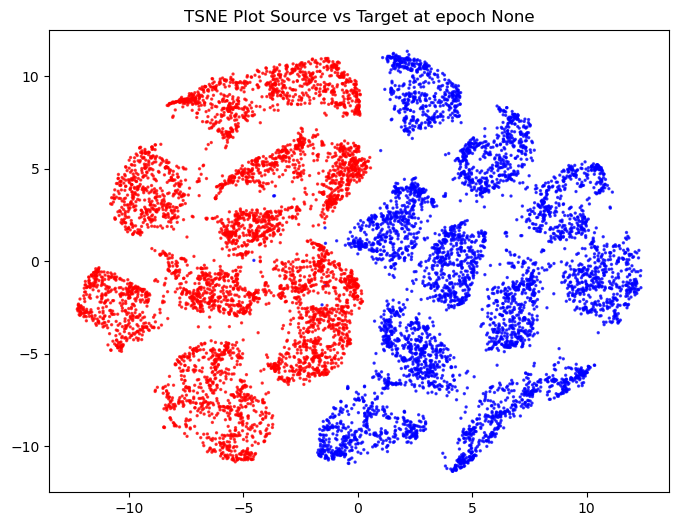

In [73]:
logs.plot_tsne_features()

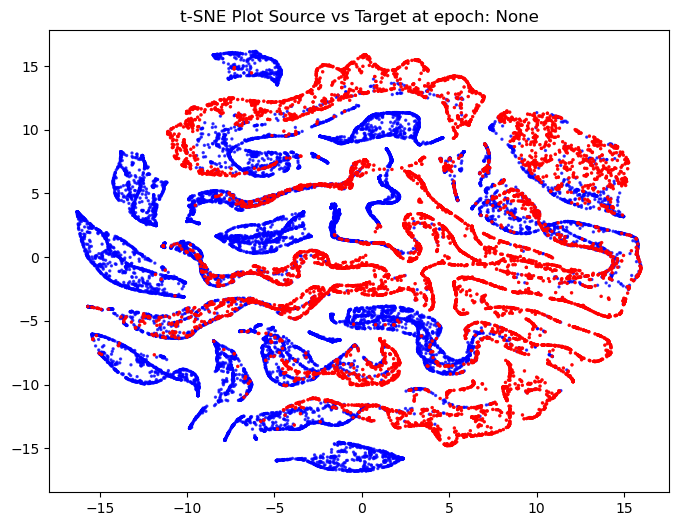

In [74]:
logs.plot_tsne()

In [75]:
logs2=display_logs(X_train, y_train, X_t, y_t, model=modelnotDA)

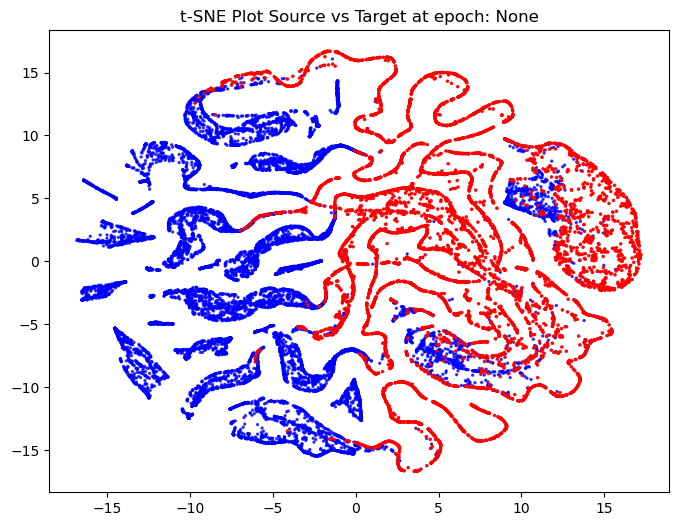

In [76]:
logs2.plot_tsne()